In [24]:
from importlib import reload
import os
from time import time

import sys
sys.path.append('/homefs/home/wongfanc/CbAS/src')

import numpy as np
import scipy as sc
import pandas as pd
import random
from sklearn.decomposition import PCA
from statsmodels.stats.weightstats import _zstat_generic


import torch
print(torch.cuda.is_available())

import pprint
import editdistance

import utils
import tdre
import shifts
import viennarna_shifts as vshifts
import calibrate as cal

import flexs
import flexs.utils.sequence_utils as s_utils

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib

import jupyternotify
ip = get_ipython()
ip.register_magics(jupyternotify.JupyterNotifyMagics)

True


<IPython.core.display.Javascript object>

In [14]:
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(
    physical_devices[0], True
)

# David's OG implementation

/homefs/home/wongfanc/miniconda3/envs/torchenv/lib/python3.11/site-packages/torch/nn/utils/weight_norm.py:30: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


Generating 5000 training and calibration data...
Done. (15 s)


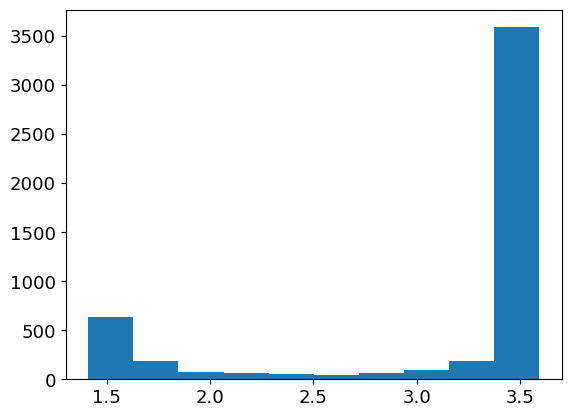

In [19]:
# generate training data around seed
avg_n_mut = 5
n = 5000

gfp_landscape = flexs.landscapes.BertGFPBrightness()
seed = gfp_landscape.gfp_wt_sequence

p_mut = avg_n_mut / 238
trainseqs_n = [vshifts.get_mutant(seed, p_mut, s_utils.AAS) for _ in range(n)]
print('Generating {} training and calibration data...'.format(n))
t0 = time()
ytrain_n = gfp_landscape.get_fitness(trainseqs_n)
print('Done. ({} s)'.format(int(time() - t0)))

plt.hist(ytrain_n);

In [52]:
from src import util, run_gfp_tests

In [64]:
reload(run_gfp_tests)
reload(util)

X_train, _, _  = util.get_experimental_X_y(random_state=0, train_size=100)
vae_0 = util.build_vae(latent_dim=20,
          n_tokens=20, 
          seq_length=X_train.shape[1],
          enc1_units=50)
vae_0.fit([X_train, X_train], # np.zeros(X_train.shape[0])],
          epochs=100,
          batch_size=10,
          verbose=2)

2024-01-10 19:49:00.843430: W tensorflow/c/c_api.cc:305] Operation '{name:'d3_15/bias/Assign' id:4398 op device:{requested: '', assigned: ''} def:{{{node d3_15/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](d3_15/bias, d3_15/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/100


AssertionError: 

In [47]:
Xt = np.array(
    [s_utils.string_to_one_hot(seq, s_utils.AAS) for seq in trainseqs_n[: 1]],
    dtype="float32",
)
weights = np.ones([n])

vae = util.build_vae(latent_dim=20, n_tokens=20, seq_length=238, enc1_units=50)
vae.fit([Xt, Xt],# [Xt], [Xt, np.zeros(Xt.shape[0])],
  epochs=10,
  batch_size=10,
  shuffle=False,
  sample_weight=[weights, weights],
  verbose=0
)

2024-01-10 19:35:10.273421: W tensorflow/c/c_api.cc:305] Operation '{name:'total_22/Assign' id:3411 op device:{requested: '', assigned: ''} def:{{{node total_22/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](total_22, total_22/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


AssertionError: 

# tune VAE to fit training distribution

2.252853858764


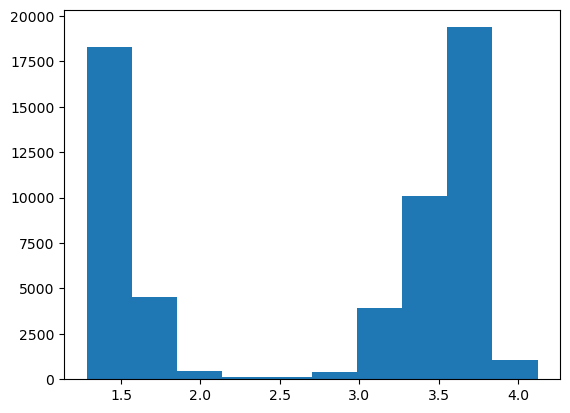

In [3]:
df = pd.read_csv('gfp_data.csv')
plt.hist(df.medianBrightness);
print(np.quantile(df.medianBrightness, 0.4))

/homefs/home/wongfanc/miniconda3/envs/torchenv/lib/python3.11/site-packages/torch/nn/utils/weight_norm.py:30: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


Generating 5000 training and calibration data...
Done. (16 s)


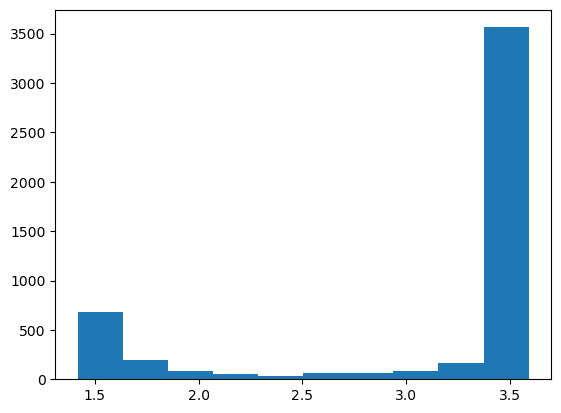

In [3]:
# generate training data around seed
avg_n_mut = 5
n = 5000

gfp_landscape = flexs.landscapes.BertGFPBrightness()
seed = gfp_landscape.gfp_wt_sequence

p_mut = avg_n_mut / 238
trainseqs_n = [vshifts.get_mutant(seed, p_mut, s_utils.AAS) for _ in range(n)]
print('Generating {} training and calibration data...'.format(n))
t0 = time()
ytrain_n = gfp_landscape.get_fitness(trainseqs_n)
print('Done. ({} s)'.format(int(time() - t0)))

plt.hist(ytrain_n);

In [3]:
new_df = pd.read_csv('gfp_data_bert.csv')

In [ ]:
# get BERT for all sequences
new_df = df[['aaSequence', 'medianBrightness']]
new_df = new_df[~new_df.aaSequence.str.contains('!')]
new_df['aaSequence'] = new_df['aaSequence'].str.upper()

print('Evaluating on {} sequences...'.format(len(new_df)))
t0 = time()
yall_n = gfp_landscape.get_fitness([s for s in new_df.aaSequence])
new_df['bert'] = yall_n
print('Done. ({} s)'.format(int(time() - t0)))
plt.scatter(new_df.medianBrightness, new_df.bert, alpha=0.5, s=5)

# new_df.to_csv('gfp_data_bert.csv')

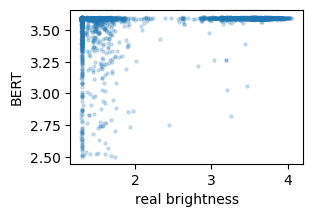

In [4]:
# training data is randomly selected from those with BERT above some threshold
n = 5000
threshold = 2.5

sel_df = new_df[new_df.bert >= threshold]
idx = np.random.choice(len(sel_df), size=n)

trainseqs_n = sel_df.aaSequence.iloc[idx].tolist()
ytrain_n = sel_df.bert.iloc[idx].to_numpy()

plt.figure(figsize=(3, 2))
plt.scatter(sel_df.medianBrightness.iloc[idx].to_numpy(), ytrain_n, alpha=0.2, s=5);
plt.xlabel('real brightness'); plt.ylabel('BERT');

In [4]:
# fit VAE to training sequences
latent_dim = 20
intermediate_dim = 50
epochs = 20 
batch_size = 10
lr = 1e-3

vae = flexs.baselines.explorers.VAE(
    238,
    s_utils.AAS,
    batch_size=batch_size,
    latent_dim=latent_dim,
    intermediate_dim=intermediate_dim,
    epochs=epochs,
    lr=lr,
    verbose=True
)

weights_n = np.ones(len(trainseqs_n))
vae.train_model(trainseqs_n, weights_n)


2024-01-09 23:24:17.885716: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 57995 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:10:1c.0, compute capability: 8.0


Epoch 1/20


/homefs/home/wongfanc/miniconda3/envs/torchenv/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
2024-01-09 23:24:18.735330: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


400/400 [==============================] - 15s 36ms/step - loss: 87.1407 - reconstruction_loss: 67.8749 - kl_loss: 19.2658 - val_loss: 0.0000e+00
Epoch 2/20
400/400 [==============================] - 14s 36ms/step - loss: 47.8739 - reconstruction_loss: 42.2205 - kl_loss: 6.9651 - val_loss: 0.0000e+00
Epoch 3/20
400/400 [==============================] - 15s 37ms/step - loss: 51.1034 - reconstruction_loss: 41.8388 - kl_loss: 5.7464 - val_loss: 0.0000e+00
Epoch 4/20
400/400 [==============================] - 15s 37ms/step - loss: 46.2124 - reconstruction_loss: 41.0598 - kl_loss: 4.6826 - val_loss: 0.0000e+00
Epoch 5/20
400/400 [==============================] - 15s 36ms/step - loss: 45.3668 - reconstruction_loss: 40.4705 - kl_loss: 3.8617 - val_loss: 0.0000e+00
Epoch 6/20
400/400 [==============================] - 15s 36ms/step - loss: 36.9102 - reconstruction_loss: 39.9024 - kl_loss: 3.0400 - val_loss: 0.0000e+00
Epoch 7/20
400/400 [==============================] - 15s 37ms/step - loss

In [5]:
gfp_landscape = flexs.landscapes.BertGFPBrightness()
gfp_wt = gfp_landscape.gfp_wt_sequence

print(f'WT sequence: {gfp_wt}, fitness: {gfp_landscape.get_fitness([gfp_wt])}')

WT sequence: MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTGKLPVPWPTLVTTLSYGVQCFSRYPDHMKQHDFFKSAMPEGYVQERTIFFKDDGNYKTRAEVKFEGDTLVNRIELKGIDFKEDGNILGHKLEYNYNSHNVYIMADKQKNGIKVNFKIRHNIEDGSVQLADHYQQNTPIGDGPVLLPDNHYLSTQSALSKDPNEKRDHMVLLEFVTAAGITHGMDELYK, fitness: [3.57231593]


In [6]:
# simulate each step of DbAS. train predictive model
model_kwargs = {
    'num_filters': 256,
    'hidden_size': 64,
    'loss': 'MSE',
    'batch_size': 128,
}

print('Training...')
t0 = time()
model = flexs.Ensemble([
    flexs.baselines.models.CNN(len(trainseqs_n[0]), alphabet=s_utils.AAS, **model_kwargs)
    for i in range(3)
])
model.train(trainseqs_n, ytrain_n)
print('Done. ({} s)'.format(int(time() - t0)))

Training...


2024-01-09 23:30:25.852841: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902
2024-01-09 23:30:25.932402: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


Done. (106 s)


In [9]:
gen_n = []
n_samples = 500
while len(gen_n) < n_samples:
    pwm_axl = vae.vae.generate()[0].numpy().T

    if (
        np.isnan(pwm_axl).any()
        or np.isinf(pwm_axl).any()
    ):
        raise ValueError("NaN and/or inf in the reconstructed matrix")

    new_seq = []
    for pos in range(238):
        new_seq.extend(random.choices(s_utils.AAS, pwm_axl[:, pos]))
    new_seq = "".join(new_seq)
    
    if (new_seq not in gen_n):
        gen_n.append(new_seq)
    else:
        print('rep')

rep
rep
rep


4/4 [==============================] - 0s 6ms/step


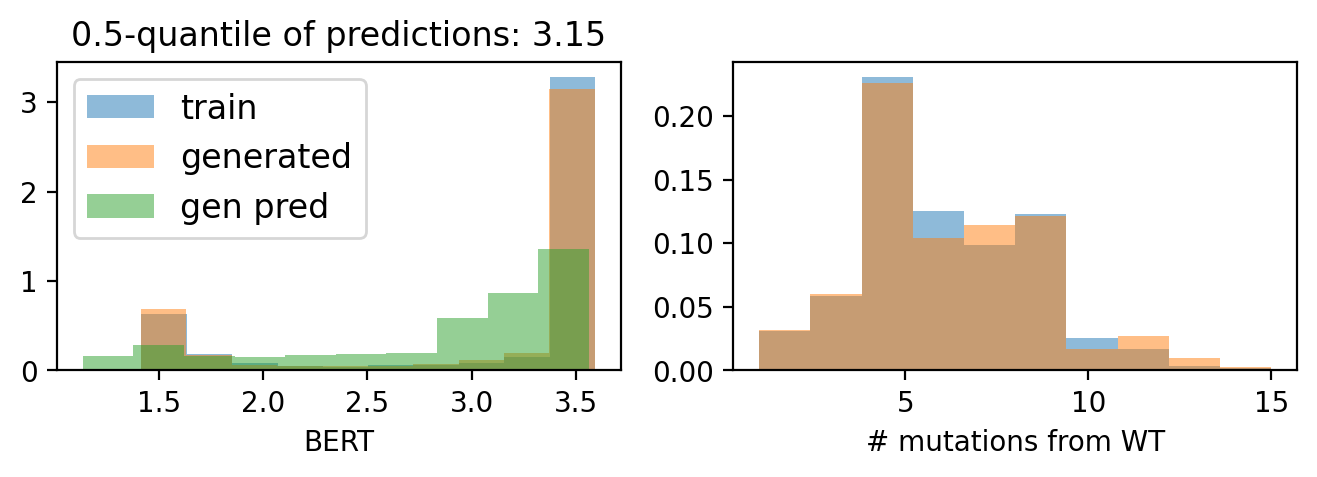

In [10]:
# generate from trained VAE
q = 0.5
# gen_n, n_rep = vae.generate(500, [])
ygen_n = gfp_landscape.get_fitness(gen_n)
predgen_n = model.get_fitness(gen_n)

plt.figure(figsize=(8, 2), dpi=200)

# compare fitnesses of train and generated sequences
plt.subplot(121)
plt.hist(ytrain_n, alpha=0.5, density=True, label='train')
plt.hist(ygen_n, alpha=0.5, density=True, label='generated')
plt.hist(predgen_n, alpha=0.5, density=True, label='gen pred')
plt.title('{}-quantile of predictions: {:.2f}'.format(q, np.quantile(predgen_n, q)))
plt.legend(fontsize=12);
plt.xlabel('BERT');

# compare distances from WT of train and generated sequences
disttrain_n = np.array([editdistance.eval(gfp_wt[1 :], s) for s in trainseqs_n])
distgen_n = np.array([editdistance.eval(gfp_wt[1 :], s) for s in gen_n])
plt.subplot(122)
plt.hist(disttrain_n, alpha=0.5,  density=True, label='train');
plt.hist(distgen_n, alpha=0.5,  density=True, label='generated');
plt.xlabel('# mutations from WT');

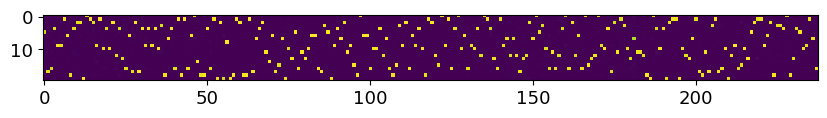

In [223]:
# seed_ohe = s_utils.string_to_one_hot(gfp_wt[1 :], s_utils.AAS)
x_reconstructed_matrix = vae1.vae.generate()[0].numpy().T

# temperature = 1
# weights = flexs.utils.VAE_utils.pwm_to_boltzmann_weights(x_reconstructed_matrix, temperature)

plt.figure(figsize=(10, 3))
# plt.imshow(seed_ohe.T - x_reconstructed_matrix);
plt.imshow(x_reconstructed_matrix);
# plt.imshow(weights)
# plt.colorbar();

# seed_idx = np.argmax(seed_ohe.T, axis=0)
# recon_idx = np.argmax(weights, axis=0)
# print(np.sum([1 for s, r in zip(seed_idx, recon_idx) if s != r]))

In [207]:
proposals = []
n_samples = 4000
while len(proposals) < n_samples:
    pwm_axl = vae.vae.generate()[0].numpy().T

    if (
        np.isnan(pwm_axl).any()
        or np.isinf(pwm_axl).any()
    ):
        raise ValueError("NaN and/or inf in the reconstructed matrix")

    new_seq = []
    for pos in range(238):
        new_seq.extend(random.choices(s_utils.AAS, pwm_axl[:, pos]))
    new_seq = "".join(new_seq)
    
    if (new_seq not in proposals):
        proposals.append(new_seq)
    else:
        print('rep')
        
scores = model.get_fitness(proposals)
gamma = np.quantile(scores, 0.7)
print('gamma = {}'.format(gamma))
weights = np.ones(len(proposals))
proposals = [p for p, s in zip(proposals, scores) if s >= gamma]

print('Number of proposals with score >= gamma: {} / {}'.format(int(np.sum(scores >= gamma)), len(proposals)))
weights[scores < gamma] = 0

# vae.train_model(proposals, weights)
vae1 = flexs.baselines.explorers.VAE(
    238,
    s_utils.AAS,
    batch_size=batch_size,
    latent_dim=latent_dim,
    intermediate_dim=intermediate_dim,
    epochs=20,
    lr=lr,
    verbose=True
)
vae1.train_model(proposals, np.ones(len(proposals)))

rep
rep
rep
rep
rep
rep
rep
rep
rep
rep
rep
rep
rep
rep
rep
rep
rep
rep
rep
rep
rep
rep
rep
rep
rep
rep
rep
rep
rep
32/32 [==============================] - 0s 6ms/step
gamma = 3.4182927131652834
Number of proposals with score >= gamma: 1200 / 1200
Epoch 1/20
96/96 [==============================] - 3s 36ms/step - loss: 187.4513 - reconstruction_loss: 136.8331 - kl_loss: 50.6182 - val_loss: 0.0000e+00
Epoch 2/20
96/96 [==============================] - 3s 36ms/step - loss: 41.2185 - reconstruction_loss: 33.1092 - kl_loss: 16.3309 - val_loss: 0.0000e+00
Epoch 3/20
96/96 [==============================] - 3s 36ms/step - loss: 34.1221 - reconstruction_loss: 31.5009 - kl_loss: 10.9285 - val_loss: 0.0000e+00
Epoch 4/20
96/96 [==============================] - 3s 36ms/step - loss: 35.1652 - reconstruction_loss: 31.5512 - kl_loss: 9.4668 - val_loss: 0.0000e+00
Epoch 5/20
96/96 [==============================] - 3s 36ms/step - loss: 48.4338 - reconstruction_loss: 31.1281 - kl_loss: 8.1529 - va

rep
8/8 [==============================] - 0s 6ms/step


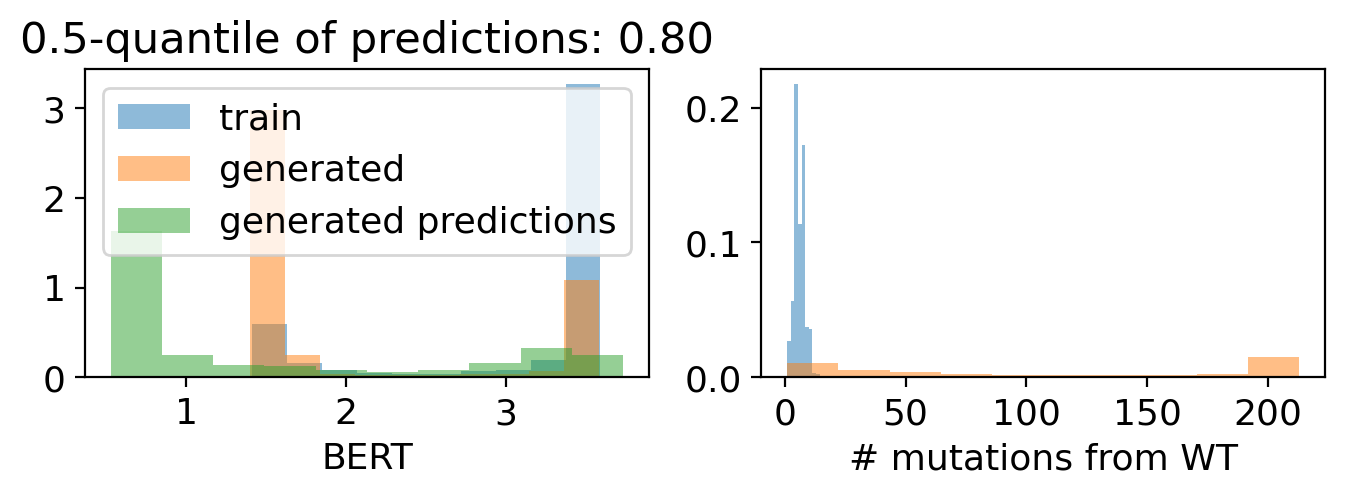

In [208]:
# generate from trained VAE
gen_n = []
n_samples = 1000
while len(gen_n) < n_samples:
    pwm_axl = vae1.vae.generate()[0].numpy().T

    if (
        np.isnan(pwm_axl).any()
        or np.isinf(pwm_axl).any()
    ):
        raise ValueError("NaN and/or inf in the reconstructed matrix")

    new_seq = []
    for pos in range(238):
        new_seq.extend(random.choices(s_utils.AAS, pwm_axl[:, pos]))
    new_seq = "".join(new_seq)
    
    if (new_seq not in gen_n):
        gen_n.append(new_seq)
    else:
        print('rep')
        
ygen_n = gfp_landscape.get_fitness(gen_n)
predgen_n = model.get_fitness(gen_n)

plt.figure(figsize=(8, 2), dpi=200)

# compare fitnesses of train and generated sequences
plt.subplot(121)
plt.hist(ytrain_n, alpha=0.5, density=True, label='train')
plt.hist(ygen_n, alpha=0.5, density=True, label='generated')
plt.hist(predgen_n, alpha=0.5, density=True, label='generated predictions')
plt.title('{}-quantile of predictions: {:.2f}'.format(q, np.quantile(predgen_n, q)))
plt.legend();
plt.xlabel('BERT');

# compare distances from WT of train and generated sequences
disttrain_n = np.array([editdistance.eval(gfp_wt[1 :], s) for s in trainseqs_n])
distgen_n = np.array([editdistance.eval(gfp_wt[1 :], s) for s in gen_n])
plt.subplot(122)
plt.hist(disttrain_n, alpha=0.5,  density=True, label='train');
plt.hist(distgen_n, alpha=0.5,  density=True, label='generated');
plt.xlabel('# mutations from WT');

# DbAS

In [50]:
n = 10000
n_cal = 5000
avg_n_mut = 5


p_mut = avg_n_mut / 238
trainseqs_n = [vshifts.get_mutant(gfp_wt, p_mut, s_utils.AAS) for _ in range(n)]
print('Generating {} labeled training and calibration data...'.format(n))
t0 = time()
ytrain_n = gfp_landscape.get_fitness(trainseqs_n)
print('Done. ({} s)'.format(int(time() - t0)))

trainseqs_n, calseqs_n = trainseqs_n[: n - n_cal], trainseqs_n[n - n_cal :]
ytrain_n, ycal_n = ytrain_n[: n - n_cal], ytrain_n[n - n_cal :]

Generating 10000 labeled training and calibration data...
Done. (31 s)


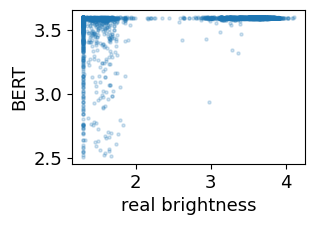

In [36]:
# training data is randomly selected from those with BERT above some threshold

new_df = pd.read_csv('gfp_data_bert.csv')
n = 10000
n_cal = 5000
threshold = 2.5

sel_df = new_df[new_df.bert >= threshold]
idx = np.random.choice(len(sel_df), size=n)

trainseqs_n = sel_df.aaSequence.iloc[idx].tolist()
ytrain_n = sel_df.bert.iloc[idx].to_numpy()

trainseqs_n, calseqs_n = trainseqs_n[: n - n_cal], trainseqs_n[n - n_cal :]
ytrain_n, ycal_n = ytrain_n[: n - n_cal], ytrain_n[n - n_cal :]

plt.figure(figsize=(3, 2))
plt.scatter(sel_df.medianBrightness.iloc[idx[: n - n_cal]].to_numpy(), ytrain_n, alpha=0.2, s=5);
plt.xlabel('real brightness'); plt.ylabel('BERT');

In [57]:
model_class = flexs.baselines.models.CNN
model_kwargs = {
    'num_filters': 256,
    'hidden_size': 64,
    'loss': 'MSE',
    'batch_size': 128,
}

print('Training...')
t0 = time()
model = flexs.Ensemble([
    model_class(len(trainseqs_n[0]), alphabet=s_utils.AAS, **model_kwargs)
    for i in range(3)
])
# model = model_class(238, alphabet=s_utils.AAS, **model_kwargs)
model.train(trainseqs_n, ytrain_n)
print('Done. ({} s)'.format(int(time() - t0)))

Training...
Done. (97 s)


In [51]:
alphas = [1e-3, 1e-2, 1e-1, 1, 10, 100, 1000]
model = flexs.baselines.models.RidgeCV(alphabet=s_utils.AAS, alphas=alphas)
model.train(trainseqs_n, ytrain_n)

40/40 [==============================] - 0s 6ms/step


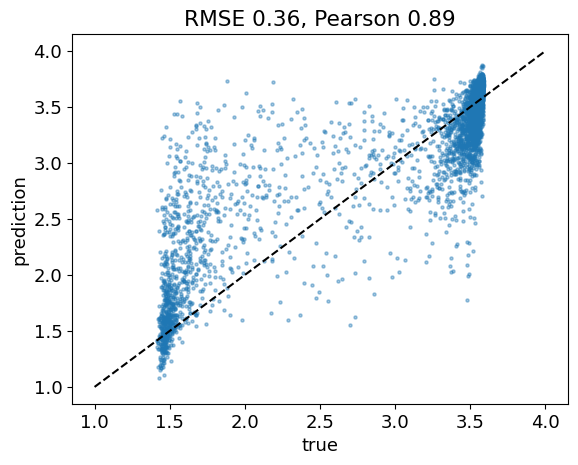

In [58]:
xy_lim = [1, 4]
predcal_n = model.get_fitness(calseqs_n)
rmse = np.sqrt(np.mean(np.square(predcal_n - ycal_n)))
r, p = sc.stats.pearsonr(predcal_n, ycal_n)
plt.scatter(ycal_n, predcal_n, alpha=0.4, s=5)
plt.xlabel('true'); plt.ylabel('prediction');
plt.plot(xy_lim, xy_lim, '--k');
plt.title('RMSE {:.2f}, Pearson {:.2f}'.format(rmse, r));

In [11]:
im

Generating 10000 training and calibration data...
Done. (31 s)
Regression model trained for Q = 0.7
40/40 [==============================] - 0s 6ms/step
Gamma of true labels of training data: 3.5636079788208006
Training initial search model. 20 epochs
Epoch 1/20
400/400 [==============================] - 15s 38ms/step - loss: 88.2960 - reconstruction_loss: 67.8108 - kl_loss: 20.4851 - val_loss: 0.0000e+00
Epoch 2/20
400/400 [==============================] - 15s 37ms/step - loss: 52.5753 - reconstruction_loss: 42.6131 - kl_loss: 6.9568 - val_loss: 0.0000e+00
Epoch 3/20
400/400 [==============================] - 15s 37ms/step - loss: 47.4694 - reconstruction_loss: 42.2295 - kl_loss: 5.5829 - val_loss: 0.0000e+00
Epoch 4/20
400/400 [==============================] - 15s 37ms/step - loss: 46.4810 - reconstruction_loss: 41.7336 - kl_loss: 4.8752 - val_loss: 0.0000e+00
Epoch 5/20
400/400 [==============================] - 15s 37ms/step - loss: 50.2921 - reconstruction_loss: 41.2251 - kl_los

160/160 [==============================] - 6s 38ms/step - loss: 34.6328 - reconstruction_loss: 34.6976 - kl_loss: 0.4533 - val_loss: 0.0000e+00
Epoch 6/10
160/160 [==============================] - 6s 38ms/step - loss: 42.6191 - reconstruction_loss: 34.6198 - kl_loss: 0.4783 - val_loss: 0.0000e+00
Epoch 7/10
160/160 [==============================] - 6s 37ms/step - loss: 31.8118 - reconstruction_loss: 34.4983 - kl_loss: 0.5163 - val_loss: 0.0000e+00
Epoch 8/10
160/160 [==============================] - 6s 37ms/step - loss: 26.6572 - reconstruction_loss: 34.3794 - kl_loss: 0.5474 - val_loss: 0.0000e+00
Epoch 9/10
160/160 [==============================] - 6s 37ms/step - loss: 37.1892 - reconstruction_loss: 34.3328 - kl_loss: 0.5953 - val_loss: 0.0000e+00
Epoch 10/10
160/160 [==============================] - 6s 37ms/step - loss: 35.8517 - reconstruction_loss: 34.2201 - kl_loss: 0.6502 - val_loss: 0.0000e+00

  Proposed 2000 sequences on search model update 7 / 20 

16/16 [==============

160/160 [==============================] - 6s 38ms/step - loss: 34.3213 - reconstruction_loss: 31.1240 - kl_loss: 1.3931 - val_loss: 0.0000e+00
Epoch 10/10
160/160 [==============================] - 6s 37ms/step - loss: 29.5923 - reconstruction_loss: 30.9974 - kl_loss: 1.4191 - val_loss: 0.0000e+00

  Proposed 2000 sequences on search model update 15 / 20 

16/16 [==============================] - 0s 6ms/step
  Gamma = 3.585842180252075
  Number of proposals with score >= gamma: 523 / 2000
  Of non-zero weights: min 1.00, quartile 1.00, median 1.00, quartile 1.00, max 1.00
  sum of weights: 523.0
Epoch 1/10
160/160 [==============================] - 6s 37ms/step - loss: 37.2427 - reconstruction_loss: 32.5257 - kl_loss: 1.3256 - val_loss: 0.0000e+00
Epoch 2/10
160/160 [==============================] - 6s 38ms/step - loss: 41.1449 - reconstruction_loss: 32.2916 - kl_loss: 1.2576 - val_loss: 0.0000e+00
Epoch 3/10
160/160 [==============================] - 6s 38ms/step - loss: 27.4119 - r

16/16 [==============================] - 0s 6ms/step
  Gamma = 3.585842180252075
  Number of proposals with score >= gamma: 531 / 2000
  Of non-zero weights: min 1.00, quartile 1.00, median 1.00, quartile 1.00, max 1.00
  sum of weights: 531.0
Epoch 1/10
160/160 [==============================] - 6s 38ms/step - loss: 29.5608 - reconstruction_loss: 31.2515 - kl_loss: 1.6626 - val_loss: 0.0000e+00
Epoch 2/10
160/160 [==============================] - 6s 37ms/step - loss: 30.8600 - reconstruction_loss: 30.9783 - kl_loss: 1.6208 - val_loss: 0.0000e+00
Epoch 3/10
160/160 [==============================] - 6s 37ms/step - loss: 32.7369 - reconstruction_loss: 30.7423 - kl_loss: 1.6541 - val_loss: 0.0000e+00
Epoch 4/10
160/160 [==============================] - 6s 37ms/step - loss: 37.4006 - reconstruction_loss: 30.6202 - kl_loss: 1.7020 - val_loss: 0.0000e+00
Epoch 5/10
160/160 [==============================] - 6s 37ms/step - loss: 28.2401 - reconstruction_loss: 30.4069 - kl_loss: 1.7059 - va

In [7]:
gfp_landscape = flexs.landscapes.BertGFPBrightness()
gfp_wt = gfp_landscape.gfp_wt_sequence

print(f'WT sequence: {gfp_wt}, fitness: {gfp_landscape.get_fitness([gfp_wt])}')

WT sequence: MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTGKLPVPWPTLVTTLSYGVQCFSRYPDHMKQHDFFKSAMPEGYVQERTIFFKDDGNYKTRAEVKFEGDTLVNRIELKGIDFKEDGNILGHKLEYNYNSHNVYIMADKQKNGIKVNFKIRHNIEDGSVQLADHYQQNTPIGDGPVLLPDNHYLSTQSALSKDPNEKRDHMVLLEFVTAAGITHGMDELYK, fitness: [3.57231593]


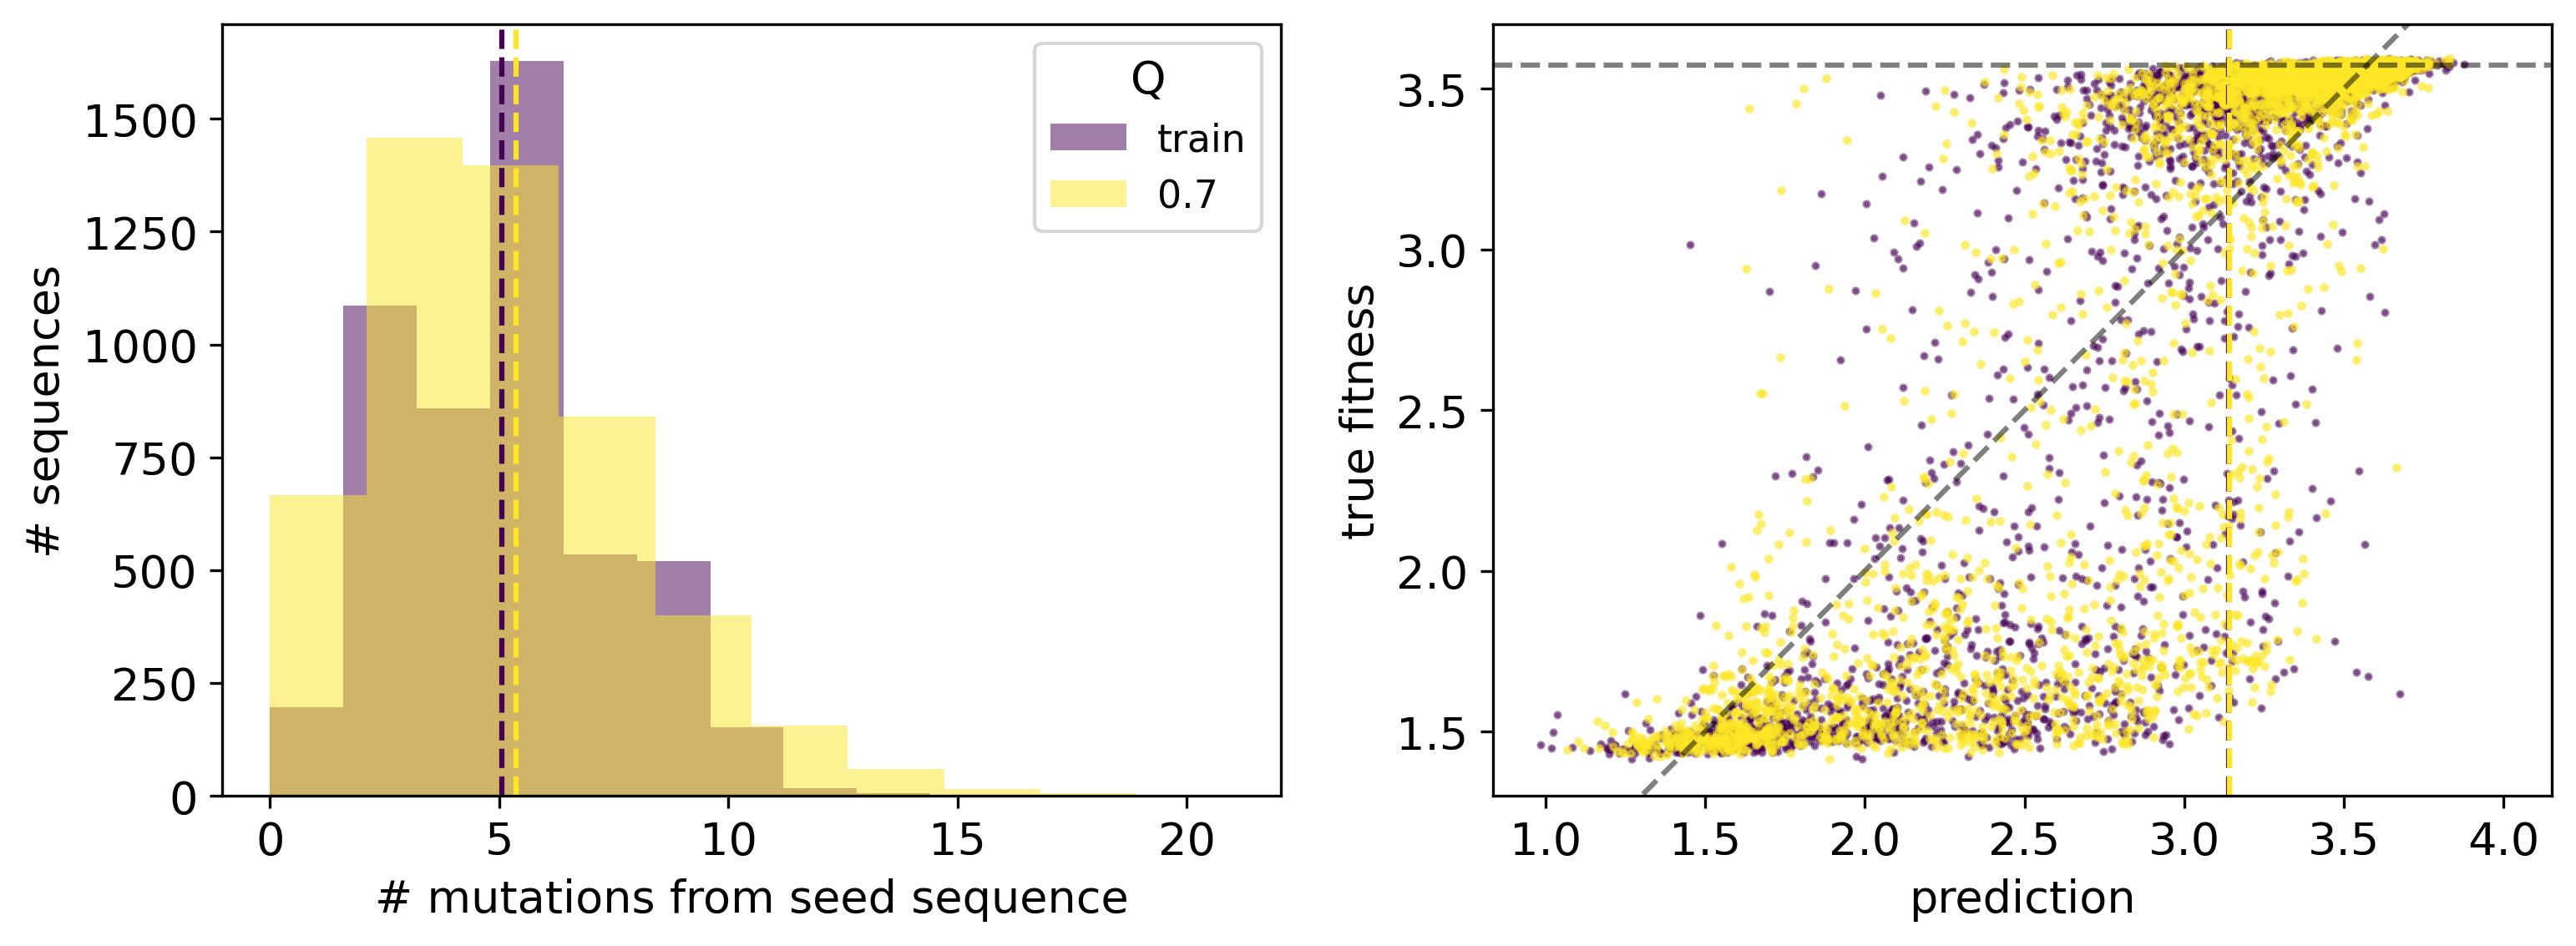

In [12]:
# pretty plot for presentations
scatter_y_lim = [1.3, 3.7]
diag_line_lim = [1, 4]
font = {'size' : 13}
matplotlib.rc('font', **font)
scatter_s = 3
cmap = matplotlib.colormaps['viridis']
disttrain_n = np.array([editdistance.eval(gfp_wt, s) for s in trainseqs_n])

plt.figure(figsize=(12, 4), dpi=300)

plt.subplot(121)
plt.hist(disttrain_n, alpha=0.5, label='train', color=cmap(0));
plt.axvline(np.mean(disttrain_n), alpha=1, linestyle='--', color=cmap(0))
plt.xlabel('# mutations from seed sequence');
plt.ylabel('# sequences');

plt.subplot(122)
plt.scatter(predcal_n, ycal_n, alpha=0.5, s=2, label='validation', color=cmap(0));
# plt.scatter(np.mean(ycal_n), np.mean(predcal_n), color=cmap(0), alpha=1, s=15, edgecolor='k');
plt.plot(diag_line_lim, diag_line_lim, '--k', alpha=0.5);
plt.axhline(gfp_landscape.get_fitness([gfp_wt]), alpha=0.5, linestyle='--', color='k')
plt.axvline(np.mean(predcal_n), alpha=1, linestyle='--', color=cmap(0))

# plt.xlim(scatter_lim);
plt.ylim(scatter_y_lim);
plt.ylabel('true fitness');
plt.xlabel('prediction');


for i, (testseqs_n, ytest_n, predtest_n) in enumerate(testseqs_list):
    color = cmap((i + 1) / len(hp_vals))
    plt.subplot(121)
    disttest_n = np.array([editdistance.eval(gfp_wt, s) for s in testseqs_n])
    plt.hist(disttest_n, alpha=0.5, label=hp_vals[i], color=color);
    plt.axvline(np.mean(disttest_n), linestyle='--', color=color)
    
    plt.subplot(122)
    plt.scatter(predtest_n, ytest_n, alpha=0.5, s=scatter_s, color=color);
    plt.axvline(np.mean(predtest_n), alpha=1, linestyle='--', color=color);

    # plt.scatter(np.mean(ytest_n), np.mean(predtest_n), color=color, alpha=1, s=10, edgecolor='k');
plt.subplot(121)
plt.legend(title=hp_name, fontsize=11);


In [ ]:
# generate multiple trials
reload(vshifts)

model_class = flexs.baselines.models.CNN
model_kwargs = {
    'num_filters': 64,
    'hidden_size': 64,
    'loss': 'MSE',
    'batch_size': 512,
}

explorer = 'cbas'
hp_name = 'Q'
hp_vals = [0.01, 0.3, 0.5, 0.7, 0.9]
explorer_kwargs = {hp_name: hp_vals}

save_fname_dir = '010323'

noise_sd = 0.0
trial_idxs = range(10)
landscape_name = 'gfp'
ns = [5000]
N = 20000
avg_n_muts = [10]

vshifts.generate_rna_data(
    model_class,
    explorer,
    explorer_kwargs,
    save_fname_dir,
    noise_sd=noise_sd,
    trial_idxs=trial_idxs,
    model_kwargs=model_kwargs,
    landscape_names=[landscape_name],
    ns=ns,
    N=N,
    avg_n_muts=avg_n_muts
)

In [ ]:
reload(vshifts)
reload(cal)
reload(tdre)

# data 
landscape_name = 'gfp'
n = 5000
N = 20000
seed_idx = 0
avg_n_mut = 10
hp_name = 'Q'
hp_vals = [0.01, 0.3, 0.5, 0.7, 0.9]
explorer_kwargs = {hp_name: hp_vals}
save_fname_dir = '010323'
trial_idx = np.arange(8)

# threshold for survival function
threshold = 3.5

# TDRE
n_hidden = 512
config = {
    'waymark_type': 'mixed_dimensions',  # dummy value
    'val_frac': 0.1,
    'n_steps': 2000,
    'lr': 1e-3,
    'use_weighted_loss': True,
    'kd_bandwidth': 0.2
}
model = tdre.TelescopingLogDensityRatioEstimator(
    None,
    238 * 20,
    n_ratio=len(hp_vals),
    n_waymarks_for_last_hp=0,
    device=torch.device('cuda'),
    dtype=torch.float,
    n_hidden=n_hidden,
    shared=False,
    multiclass=True,
    cranmer=False,
)

true_txm = np.zeros([trial_idx.size, len(hp_vals)])
imp_txm = np.zeros([trial_idx.size, len(hp_vals)])
format_str = ''.join(['{}'] + len(hp_vals) * ['{:.3f} '])

for T_idx, T in enumerate(trial_idx):

    X_mxnxd, y_mxn, pred_mxn, Xtrcal_nxd, Xcal_nxd, ycal_n, predcal_n = vshifts.load_rna_data(
        landscape_name,
        seed_idx,
        n,
        N,
        explorer_kwargs,
        save_fname_dir,
        avg_n_mut,
        trial_idx=T
    )

    # train_dfs = model.fit(config, X_m1xnxd=X_mxnxd, Xm_nxp=Xtrcal_nxd)
    
    truemean_m = np.mean(y_mxn >= threshold, axis=1)
    true_txm[T_idx] = truemean_m
    
    # imputation point estimates
    imputed_m = np.mean(pred_mxn >= threshold, axis=1)
    imp_txm[T_idx] = imputed_m
    
    print('Train mean: {:.3f}'.format(np.mean(ycal_n)))
    print(format_str.format('True means          :', *truemean_m))
    print(format_str.format('Imputed means       :', *imputed_m))

In [ ]:
loc = np.arange(len(hp_vals))
plt.violinplot(imp_txm - true_txm, loc - 0.2, widths=0.2, showmeans=True);
# plt.violinplot(ppa_txm - true_txm, loc, widths=0.2, showmeans=True);
plt.axhline(0, linestyle='--', color='gray')
plt.xticks(loc, labels=hp_vals)
plt.xlabel('HP');
plt.ylabel('forecast - true P(fitness > {})'.format(threshold));